In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
import seaborn as sns

os.getcwd()

'/home/mgteus/workspace/neuro/transformers_andrej'

In [2]:
from attention_model import Head, get_batch, RMSELoss

In [3]:
CONTEXT_LEN = 30
BATCH_SIZE = 4
DROPOUT = 0.1
LEARNING_RATE = 1e-3
NUM_EPOCHS = 1000
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
DEVICE

'cpu'

In [5]:
model = Head(context_len=CONTEXT_LEN, batch_size=BATCH_SIZE, dropout=DROPOUT)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [6]:
loss_list = []

for epoch in range(NUM_EPOCHS):
    xb, yb = get_batch(context_len=CONTEXT_LEN, batch_size=BATCH_SIZE, split='train', device=DEVICE)
    optimizer.zero_grad(set_to_none=True)
    predictions = model(xb)
    loss = RMSELoss(predictions, yb)
    loss_list.append(loss.item())
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0 or epoch == NUM_EPOCHS -1:
        print(f"iter. {epoch} - loss = {loss.item():4f}")

iter. 0 - loss = 0.467279
iter. 100 - loss = 0.314123
iter. 200 - loss = 0.174263
iter. 300 - loss = 0.246655
iter. 400 - loss = 0.212948
iter. 500 - loss = 0.289262
iter. 600 - loss = 0.244566
iter. 700 - loss = 0.252137
iter. 800 - loss = 0.249584
iter. 900 - loss = 0.290574
iter. 999 - loss = 0.263909


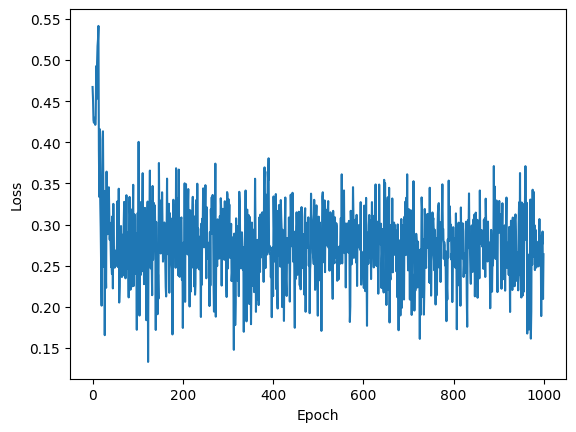

In [8]:
plt.plot(loss_list)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [9]:
np_predictions = predictions.detach().numpy()

In [10]:
np_true = yb.numpy()
np_context = xb.detach().numpy()

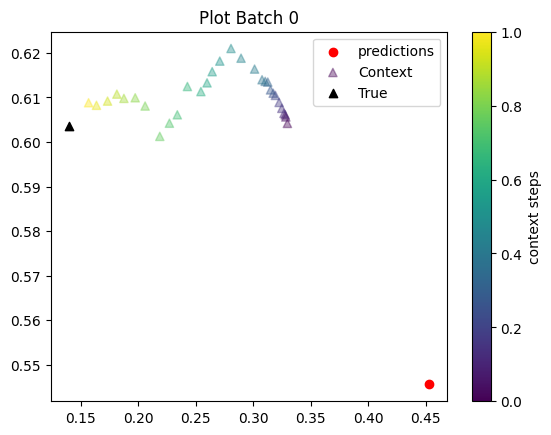

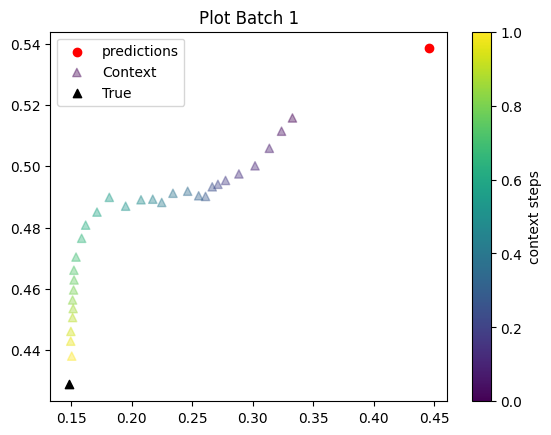

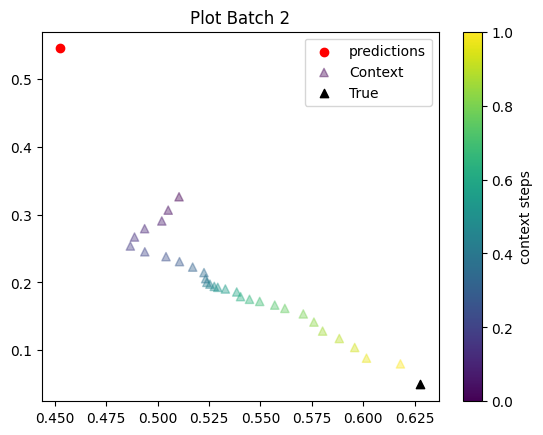

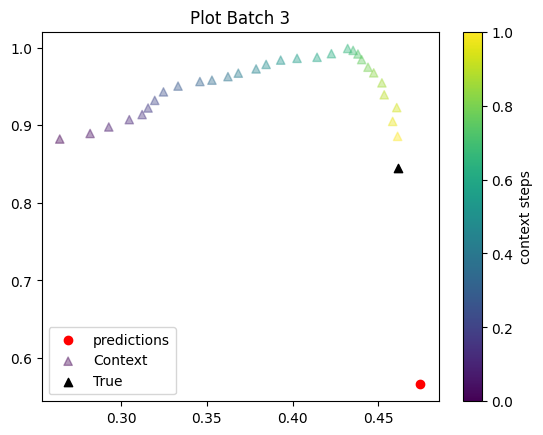

In [11]:
for i in range(BATCH_SIZE):
    plt.title(f'Plot Batch {i}')
    plt.scatter(np_predictions[i, 0], np_predictions[i, 1], label='predictions', c='r')
    plt.scatter(np_context[i, :,0], np_context[i, :, 1], label='Context', c=[color for color in range(len(np_context[i, :, 1]))], alpha=0.4, marker='^')
    plt.scatter(np_true[i, 0], np_true[i, 1], label='True', c='k', marker='^')
    plt.legend()
    plt.colorbar(label='context steps')
    # plt.xlim(0, 1)
    # plt.ylim(0, 1)
    plt.show()

In [12]:
print(model)

Head(
  (pos_to_enc_layer): Linear(in_features=2, out_features=2, bias=True)
  (enc_layer): Linear(in_features=2, out_features=1, bias=True)
  (output_layer): Linear(in_features=30, out_features=2, bias=True)
  (key): Linear(in_features=30, out_features=30, bias=True)
  (query): Linear(in_features=30, out_features=30, bias=True)
  (values): Linear(in_features=30, out_features=30, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [20]:
key_weight = model.key.weight.detach().numpy()
query_weight = model.query.weight.detach().numpy()
values_weight = model.values.weight.detach().numpy()

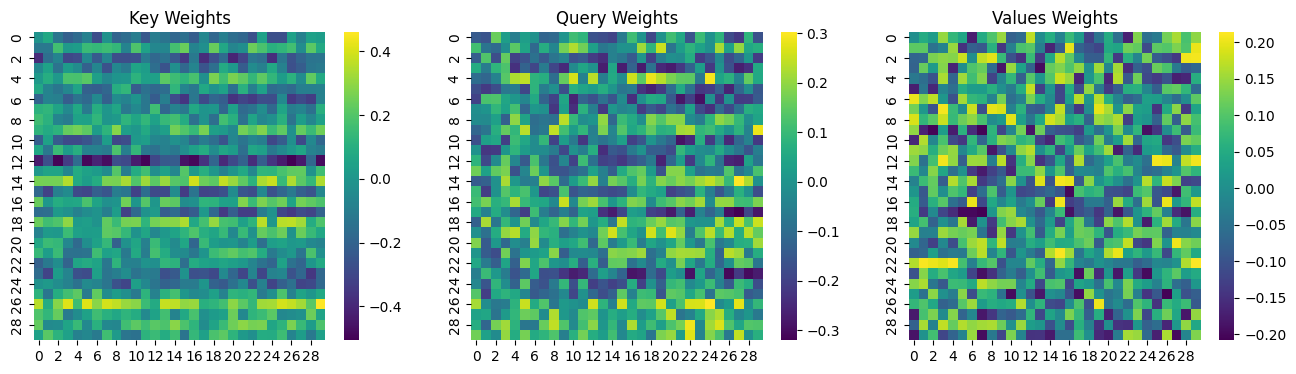

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

sns.heatmap(key_weight, cmap='viridis', ax=ax[0])
ax[0].set_title('Key Weights')

sns.heatmap(query_weight, cmap='viridis', ax=ax[1])
ax[1].set_title('Query Weights')

sns.heatmap(values_weight, cmap='viridis', ax=ax[2])
ax[2].set_title('Values Weights')
plt.show()